In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from alg import *
from utils import *

## Simple example
Easy yet non-trivial instance to test algorithm correctness.

In [2]:
num_resources = 3
processing_times = [5, 5, 4, 4, 3, 3, 3]

schedule, stats1 = bnb(R=num_resources, p=processing_times, h=h1)
_, stats2 = bnb(R=num_resources, p=processing_times, h=h2)

stats1.makespan, stats2.makespan

(9.0, 9.0)

In [3]:
gantt_df = gantt(R=num_resources, p=processing_times, s=schedule)
gantt_df

,task,start,finish,resource
0,0,0.0,5.0,0
1,2,5.0,9.0,0
2,1,0.0,5.0,1
3,3,5.0,9.0,1
4,4,0.0,3.0,2
5,5,3.0,6.0,2
6,6,6.0,9.0,2


## Comparison of no. expanded nodes

### Heuristic comparison
1. ratio `h2/h1` of no. expanded nodes on *sub-optimal instances* (instance with processing times `[2*R - 1, 2*R - 1, 2*R - 2, 2*R - 2, ..., R - 1, R - 1, R, R, R]`)
2. ratio `h2/h1` of no. expanded nodes on *random instances* (avg. on 10 samples for each no. tasks `n` with integer processing times in `[1, 10]`)

In [4]:
num_instances = 26

def percent_explored_nodes(h):
    return pd.Series([evaluate(lambda s: s.expanded, R, p, h) for R, p in generate_subopt_instances(num_instances)])

In [5]:
explored_df = pd.DataFrame({h.__name__: percent_explored_nodes(h) for h in [h1, h2]})
explored_df.tail()

,h1,h2
21,62170,9777
22,86374,10809
23,121784,13208
24,150803,63543
25,174858,15205


In [6]:
ratio_col = f'{h2.__name__}/{h1.__name__}'

explored_df[ratio_col] = explored_df[h2.__name__] / explored_df[h1.__name__]
explored_df.tail()

,h1,h2,h2/h1
21,62170,9777,0.157262
22,86374,10809,0.125142
23,121784,13208,0.108454
24,150803,63543,0.421364
25,174858,15205,0.086956


<AxesSubplot:xlabel='#resources', ylabel='ratio h2/h1 of #explored nodes'>

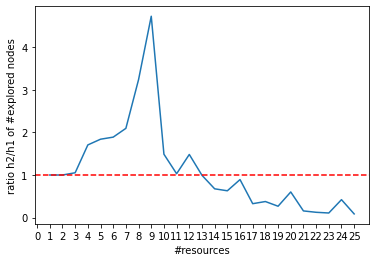

In [7]:
ax = explored_df[ratio_col].plot.line(xlabel='#resources', ylabel=f'ratio {ratio_col} of #explored nodes', xticks=range(num_instances))
ax.axhline(y=1, color='r', linestyle='--')
ax

In [8]:
pt_max = 10
num_trials = 10
N = 30
num_resources = 20

instances = {
    (n, i): random_instance(n, pt_max)
    for n in range(N)
    for i in range(num_trials)
}

def eval_explored_ratio(R, p):
    return evaluate(lambda s: s.expanded, R, p, h2) / evaluate(lambda s: s.expanded, R, p, h1)

def explored_ratio(R):
    df = pd.DataFrame([[eval_explored_ratio(R, instances[n, i]) for i in range(num_trials)] for n in range(N)])
    return df.mean(axis=1)

In [9]:
rand_explored_df = pd.DataFrame({f'R{R}': explored_ratio(R) for R in range(4, 17, 4)})
rand_explored_df.tail()

,R4,R8,R12,R16
25,1.000000,0.940830,1.015447,1.0
26,0.981973,0.940954,1.009286,1.1
27,0.969565,0.908731,1.121111,1.1
28,1.000000,0.935911,1.014027,1.1
29,1.000000,0.899727,1.280851,1.1


<AxesSubplot:xlabel='#tasks', ylabel='mean ratio h2/h1 of #explored nodes'>

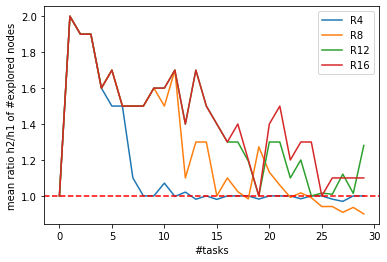

In [10]:
ax = rand_explored_df.plot.line(xlabel='#tasks', ylabel=f'mean ratio {ratio_col} of #explored nodes')
ax.axhline(y=1, color='r', linestyle='--')
ax

## Comparison of max. no. open nodes
Comparison of the maximum sizes of queues during the search for h1 and h2 on *sub-optimal instances* of varying `R`.

In [11]:
num_instances = 26

def max_open_nodes(h):
    return pd.Series([evaluate(lambda s: s.max_open, R, p, h) for R, p in generate_subopt_instances(num_instances)])

In [12]:
max_open_df = pd.DataFrame({h.__name__: max_open_nodes(h) for h in [h1, h2]})
max_open_df.tail()

,h1,h2
21,42022.0,495.0
22,59012.0,519.0
23,83694.0,592.0
24,104960.0,669.0
25,123683.0,679.0


<AxesSubplot:xlabel='#resources', ylabel='max. open nodes'>

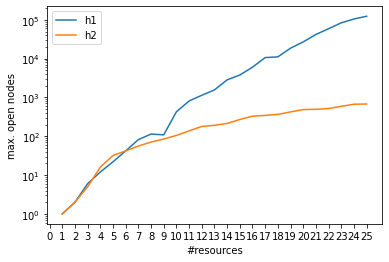

In [13]:
max_open_df.plot.line(xlabel='#resources', ylabel='max. open nodes', xticks=range(num_instances), logy=True)